# NOTE: no access to cluster yet, results are for sub 1

# Functional connectivity within subjects


<img src="http://drive.google.com/uc?export=view&id=1GPJ8XWcvqHr9NnyVm2DubagzV7cBPvsR" style="height:250px"/>

- The correlation of the time course of activity from the seed voxel with the time series from the target voxel is a proxy for the functional connectivity between those areas. 
- We have strong hypotheses about how information should flow in the brain. So instead of doing these analyses for the whole brain we do them for specific regions (`==ROI==pairs of voxels`).
- BOLD signal is noisy, remove noise and correct for movement $\rightarrow$ residuals. We do this analysis with the residuals, which is a proxy for the actual BOLD signal. 


See the [brainiak connectivity tutortial - 08](https://brainiak.org/tutorials/08-connectivity/) for more info.



<font color=red> TODO: As soon as I can access the cluster, can do analysis for all subjects. Should I do the same thing as before (i.e. collapsing the r values across subjects)?</font>

In [185]:
import warnings
import h5py
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn import input_data

from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nibabel.affines import apply_affine
import nibabel as nib
import time

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio
from scipy import stats
from numpy.linalg import inv
from numpy import inf

# import own functions
import utils
reload(utils)

sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

# 1. Load masks, residuals & specify params 

- Only take the residuals `'R'`, omit the rest of the variables.
- Save residuals as `.npy` files so that we can throw away the large files

In [2]:
path = '/Users/Daphne/data/'

# mask_nii is the functional mask, this selects the brain voxels
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 
# this where we plot our mask ON (sometimes called brain_nii) - the anatomical/structural image
mean_nii = nib.load(os.path.join(path, 'mean.nii')) 

# inverse of the affine matrix: mni2cor
inv_affine = inv(mask_nii.affine) # get the transformation matrix

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
mask_mat = mask_arr[0] # so we can pick any one from the array
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows

# residuals
R = np.load(path+'residuals_sub1.npy')
R = np.swapaxes(R,1,0)

In [3]:
R.shape

(1698, 220075)

In [ ]:
## uncomment and do for all subjects
# path = '/Users/Daphne/data/'
# filename = 'residuals_glm9_subj1_smooth.mat'

# data = h5py.File(path+filename,'r') 

# print(data.keys())
# print(data['R'].value.shape)

# residuals_sub1 = data['R'].value # store residuals for subject

# np.save('residuals_sub1', residuals_sub1)

# 2. Pick a seed

- We loaded the whole-brain residuals
- Now, we pick ROIs (== seed voxel) and correlate their activity with other voxels in the brain
- If we find voxels that are correlated with a seed ROI, this suggests that these voxels are functionally connected

### How to choose the seed voxels

1. Use momchils voxels
2. Use the voxels found with my own analysis (see `find_ROIs.ipynb`)


## 2.1 Create a spherical ROI with a seed voxel

[NiftiSpheresMasker](http://nilearn.github.io/modules/generated/nilearn.input_data.NiftiSpheresMasker.html)

In [7]:
# theory ROIs (model-based) 
# all MNI coordinates!
R_IFG_Tri = [42, 28, 26]
L_Insula = [-30, 28, 2]
R_DMPFC = [6, 38, 40]
L_IFG_Tri = [-50, 44, 12]
L_MTG = [-64, -50, 4]
R_MTG = [58, -36, 8]

# control voxel
# tip: can always try the contralateral ROIs: [-x y z]
L_lingual = [2, -86, 4]
Occipital = [-36 -88 -12

In [148]:
# create dictionary to map points to roi names
roi_dict = {'right inferior frontal gyrus (Tri)':R_IFG_Tri, 'left_insula':L_Insula, 'right dorsalmedial PFC':R_DMPFC,
            'left inferior frontal gyrus (Tri)':L_IFG_Tri, 'left middle temporal gyrus':L_MTG, 'right middle temporal gyrus':R_MTG
           }
# map control voxels to names
control_dict = {'control vox (left lingual)':L_lingual, 'control vox (Occipital)':Occipital}

In [194]:
# get the voxels for all corresponding voxels above for later
roi_voxel_indices = []

for key, value in roi_dict.items():

    mni_c = value
    native_coords_c = apply_affine(aff=inv_affine, pts=mni_c) # from mni2cor
    vox_num = utils.get_vox_from_coords(coords_mat, native_coords_c) # corresponding voxel
    
    roi_voxel_indices.append(vox_num)

The coordinates correspond to voxel: 146217.
The coordinates correspond to voxel: 89655.
The coordinates correspond to voxel: 175423.
The coordinates correspond to voxel: 114273.
The coordinates correspond to voxel: 91966.
The coordinates correspond to voxel: 102081.


In [168]:
# === CHOOSE COORDINATES === (must be MNI)
coords_roi = R_IFG_Tri
coords_control = L_lingual
# ==========================

# Init the masking object
masker_ROI = input_data.NiftiSpheresMasker(
    coords_roi, 
    radius=8, standardize=True, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0
)

In [169]:
def find_key(input_dict, value):
    return [k for k, v in input_dict.items() if v == value][0]

In [171]:
#find_key(roi_dict, coords_roi)

## 2.2 Plot the signal for the ROI



In [9]:
hdr = mask_nii.get_header()
hdr.get_xyzt_units() # so we see the voxel size & time units

('mm', 'sec')

In [10]:
# get the corresponding voxel for ROI ...
native_coords_roi = apply_affine(aff=inv_affine, pts=coords_roi) # from mni2cor
roi_vox = utils.get_vox_from_coords(coords_mat, native_coords_roi) # corresponding voxel

# and control voxel
native_coords_control = apply_affine(aff=inv_affine, pts=coords_control) # from mni2cor
control_vox = utils.get_vox_from_coords(coords_mat, native_coords_control) # corresponding voxel

The coordinates correspond to voxel: 146217.
The coordinates correspond to voxel: 90918.


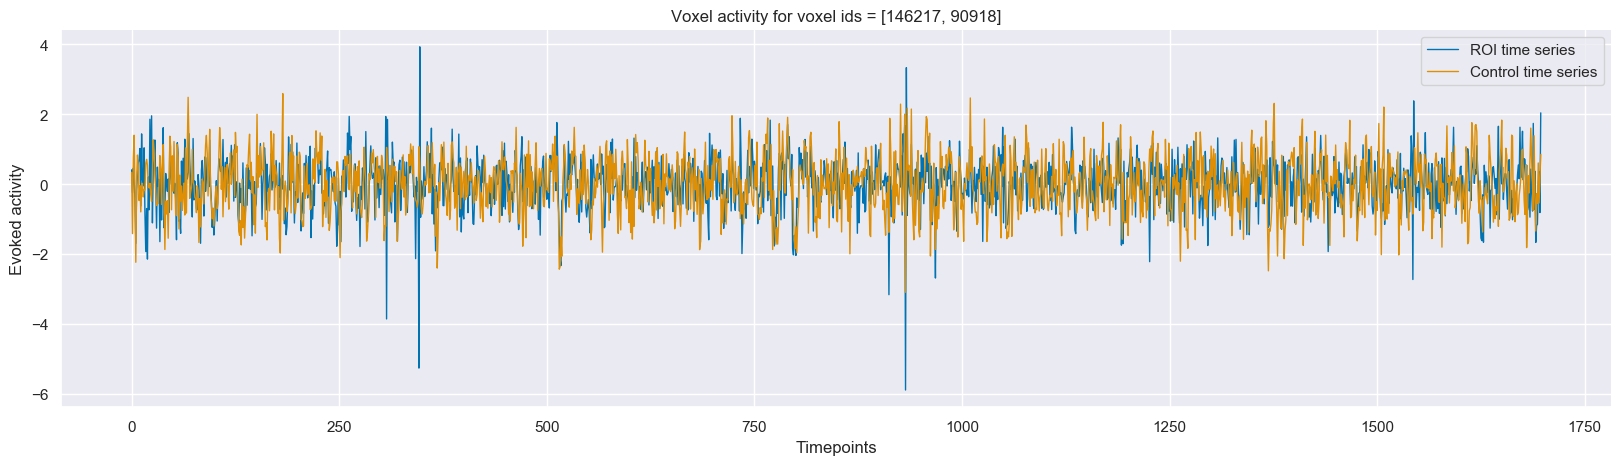

In [11]:
"""
Plot the timeseries for the roi and control voxels
"""
voxel_ids = [roi_vox, control_vox]

plt.figure(figsize=(20, 5), dpi=100)
plt.title(f'Voxel activity for voxel ids = {voxel_ids}');
plt.plot(R[:, voxel_ids[0]], linewidth=1, label='ROI time series');
plt.plot(R[:, voxel_ids[1]], linewidth=1, label='Control time series');
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
plt.legend();
sns.despine()

# 3. Compute the correlations with seed and control voxel

- In seed analysis we compute the cross correlation between the time series of the seed voxel and all other voxels. So we just do

```Python
For all voxels in whole brain mask

    correlate with seed voxel
```

### Caveats

- May have different hemodynamic lags in different regions



In [184]:
def corr_with_seed(R, seed_vox):

    num_voxels = R.shape[1]
    seed_corr = np.zeros((num_voxels, 1)) # make volume to store the correlations
    
    for v in range(num_voxels):
        seed_corr[v, 0] = round(np.corrcoef(R[:,v], R[:, seed_vox])[0,1], 3) # take one value 

    # Transfrom the correlation values to Fisher z-scores    
    seed_corr_fishZ = np.arctanh(seed_corr)
    # arctanh(1)=inf so replace inf values with 2.7
    seed_corr_fishZ[seed_corr_fishZ == inf] = 2.7

    return seed_corr, seed_corr_fishZ

In [125]:
def corr_with_control(R, control_vox):

    num_voxels = R.shape[1]
    control_corr = np.zeros((num_voxels, 1)) # make volume to store the correlations
    
    for v in range(num_voxels):
        control_corr[v, 0] = round(np.corrcoef(R[:,v], R[:, control_vox])[0,1],3) # take one value 

    # Transfrom the correlation values to Fisher z-scores    
    control_corr_fishZ = np.arctanh(control_corr)
    # arctanh(1)=inf so replace inf values with 2.7
    control_corr_fishZ[control_corr_fishZ == inf] = 2.7

    return control_corr, control_corr_fishZ

In [126]:
# correlate all with seed voxel
corr_roi, corr_fz_roi = corr_with_seed(R=R, seed_vox=roi_vox)

# correlate all with control voxel
corr_control, corr_fz_control = corr_with_control(R=R, control_vox=control_vox)

In [127]:
np.arctanh(0.99) # becomes inf

2.6466524123622457

In [128]:
corr_fz_roi.shape

(220075, 1)

In [129]:
np.isinf(corr_fz_roi).any() # contains inf elements

False

In [130]:
min(corr_fz_roi)

array([-0.42603216])

In [131]:
np.sort(corr_fz_roi)

array([[-0.02000267],
       [-0.01000033],
       [-0.05806517],
       ...,
       [ 0.14602922],
       [ 0.12464147],
       [ 0.33387687]])

In [132]:
print(corr_roi)

[[-0.02 ]
 [-0.01 ]
 [-0.058]
 ...
 [ 0.145]
 [ 0.124]
 [ 0.322]]


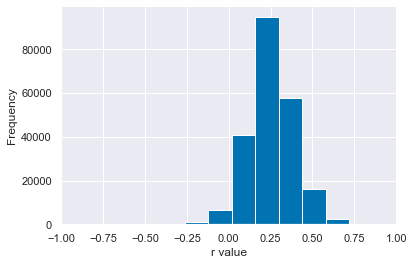

In [133]:
plt.hist(corr_roi)
plt.ylabel('Frequency');
plt.xlabel('r value');
plt.xlim([-1,1])
sns.despine()

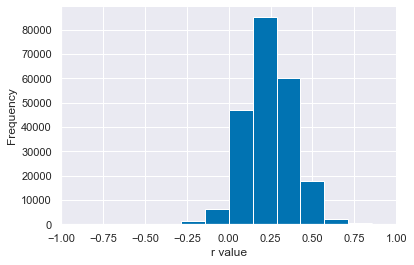

In [134]:
plt.hist(corr_control)
plt.ylabel('Frequency');
plt.xlabel('r value');
plt.xlim([-1,1])
sns.despine()

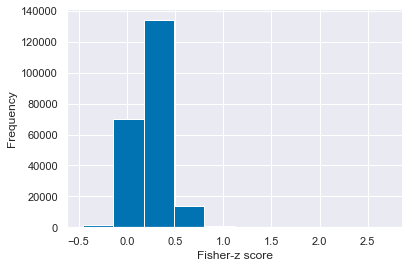

In [135]:
plt.hist(corr_fz_control)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');
sns.despine()

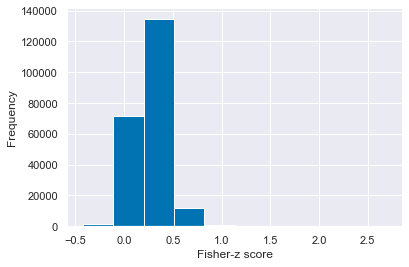

In [136]:
plt.hist(corr_fz_roi)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');
sns.despine()

# 4. Visualise correlations on anatomical image

now we want to map the correlations back on the brain???

- Plot the seed correlation with every other voxel
- with stat_map
- convert correlations to nifti image?

[add_markers](https://github.com/nilearn/nilearn/blob/21fdc532dee895b5e46c3fc6a3d4f9803b247ac1/nilearn/plotting/displays.py#L923)

In [139]:
coords = tuple(coords_mat) # needs to be a tuple in order to work

# 1) create a volume from mask_nii
volume = np.zeros(mask_nii.shape) 

# 2) Map the r values into brain space
volume[coords] = corr_fz_roi[:,0]

# 3) Create a nifti image from this with the affine from mask_nii
nii_corr_roi = nib.Nifti1Image(volume, mask_nii.affine, mask_nii.header)

In [140]:
coords_roi

[42, 28, 26]

In [141]:
# have to reshape in order to plot the seed on nifti object
coords_roi_arr = np.array(coords_roi)
coords_roi_arr = coords_roi_arr.reshape(1,3)
coords_roi_arr.shape

(1, 3)

# One ROI

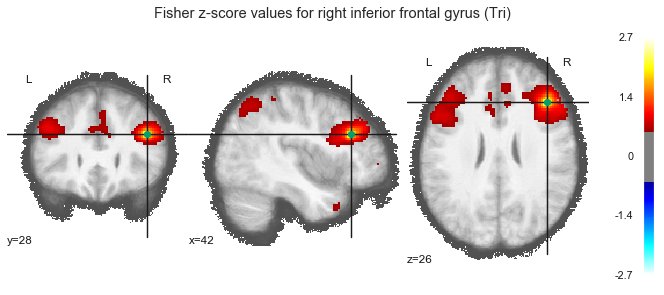

In [182]:
f, ax = plt.subplots(1,1, figsize = (12, 5), dpi=70)
roi_name = find_key(roi_dict, coords_roi)

# Nilearn has useful tools for plotting our results as a map
r_map_ar = plotting.plot_stat_map(
    nii_corr_roi,
    threshold=0.6,
    cut_coords=coords_roi,
    annotate=True,
    bg_img=mean_nii,
    black_bg=False,
    axes=ax,
);

# Add the seed
r_map_ar.add_markers(
    marker_coords=coords_roi_arr, 
    marker_color='g',
    marker_size=40,
)

ax.set_title(f'Fisher z-score values for {roi_name}', size=15); 

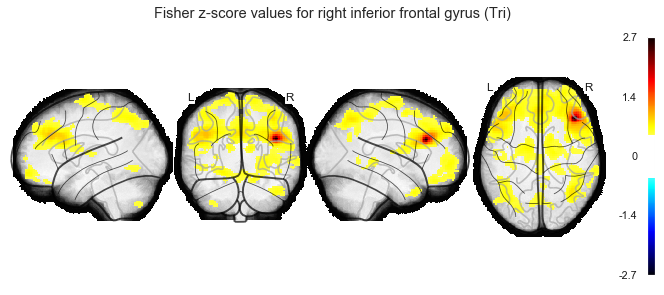

In [183]:
f, ax = plt.subplots(1,1, figsize = (12, 5), dpi=70)
roi_name = find_key(roi_dict, coords_roi)

# Create a glass brain
plotting.plot_glass_brain(
    nii_corr_roi,
    axes=ax,
    threshold=0.5,
    colorbar=True,  
    plot_abs=False,
    cut_coords=coords_roi,
    annotate=True,
    bg_img=mean_nii,
    black_bg=False,
    display_mode='lyrz', 
);

ax.set_title(f'Fisher z-score values for {roi_name}', size=15); 

# Display correlations with control value


In [187]:
coords = tuple(coords_mat) # needs to be a tuple in order to work

# 1) create a volume from mask_nii
volume = np.zeros(mask_nii.shape) 

# 2) Map the r values into brain space
volume[coords] = corr_fz_control[:,0]

# 3) Create a nifti image from this with the affine from mask_nii
nii_corr_control = nib.Nifti1Image(volume, mask_nii.affine, mask_nii.header)

# have to reshape in order to plot the seed on nifti object
coords_control_arr = np.array(coords_control)
coords_control_arr = coords_control_arr.reshape(1,3)
coords_control_arr.shape

(1, 3)

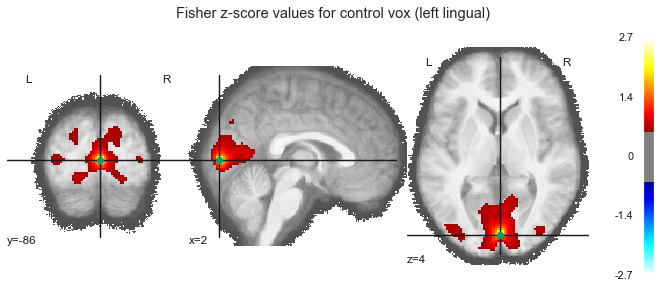

In [188]:
f, ax = plt.subplots(1,1, figsize = (12, 5), dpi=70)
control_name = find_key(control_dict, coords_control)

# Nilearn has useful tools for plotting our results as a map
r_map_ar = plotting.plot_stat_map(
    nii_corr_control,
    threshold=0.6,
    cut_coords=coords_control,
    annotate=True,
    bg_img=mean_nii,
    black_bg=False,
    axes=ax,
);

# Add the seed
r_map_ar.add_markers(
    marker_coords=coords_control_arr, 
    marker_color='g',
    marker_size=40,
)

ax.set_title(f'Fisher z-score values for {control_name}', size=15); 

# 5. Display correlation matrix and connectome

> How are the seed voxels correlated with each other?


In [207]:
roi_voxel_indices 

[146217, 89655, 175423, 114273, 91966, 102081]

In [204]:
R.shape

(1698, 220075)

In [208]:
# make a new array with only time series from selected voxels
# correlate all with each other
R[:, roi_voxel_indices].shape

(1698, 6)

In [210]:
roi_time_series = R[:, roi_voxel_indices]

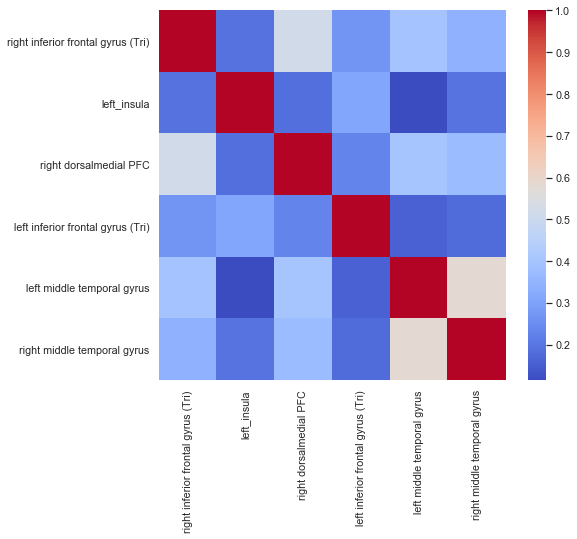

In [243]:
df = pd.DataFrame(roi_time_series) # convert to df
corr_matrix = df.corr('pearson').abs() # correlate all cols

f, ax = plt.subplots(1,1, figsize = (8, 7), dpi=70)

# Select upper triangle of correlation matrix
#upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
 
sns.heatmap(corr_matrix, 
            cmap='coolwarm',
            xticklabels=roi_dict.keys(),
            yticklabels=roi_dict.keys(),
            axes=ax
            );

In [250]:
np.array(list(roi_dict.values())).shape

(6, 3)

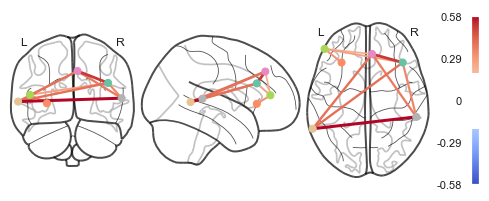

In [258]:
plotting.plot_connectome(adjacency_matrix=corr_matrix,
                         node_coords=np.array(list(roi_dict.values())),
                         edge_threshold=0.2,
                         edge_cmap='coolwarm',
                         colorbar=True
                         );